# Identify Alleles with Cell Count Differences

In [13]:
# Imports
import os
import warnings
import numpy as np
import polars as pl
import pandas as pd
from tqdm import tqdm
import statsmodels.formula.api as smf
from scipy.stats import ttest_rel, ttest_ind
import sys
sys.path.append("../..")
from img_utils import *

## 1. Summarize Cell Count Profiles

### 1.1 Allele Metadata

In [14]:
img_well_qc_sum_df = pl.read_parquet(IMG_QC_SUM_PARQUET_FILE)
img_well_qc_sum_df.head()

plate,well,channel,mean,std,perc_25,perc_50,perc_75,perc_80,perc_90,perc_95,perc_99,Metadata_Batch,mean_plate,std_plate,perc_25_plate,median_plate,perc_75_plate,perc_80_plate,perc_90_plate,perc_95_plate,perc_99_plate,s2n_ratio_raw,s2n_ratio,Metadata_Bio_Batch,is_bg,plate_id,plate_well,plate_map_name,well_position,symbol,gene_allele,imaging_well,imaging_plate_R1,imaging_plate_R2,node_type,orf_id_wt,ccsb_mutation_id,nt_change_cdna,aa_change,allele_set,imaging_plate,batch1,batch2,clone_ID,vector,notes,quad,c96,r96,r384,c384,r384_letter,source_plate,source_well,source_numb,dest_plate,dest_well,dest_numb,technical_replicate,symbol_original,sequencing_confidence,hgmd_ID,clinvar_allele_ID,clinvar_clinical_significance
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,bool,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,f64,f64,f64,f64,str,f64,str,f64,f64,f64,f64,f64,str,str,str,f64,str,str,f64,f64,str,str,str,str,str
"""2024_01_17_B7A1R1_P1T1""","""P10""","""DNA""",200.943084,225.809537,172.0,194.0,214.0,219.0,229.0,237.0,256.0,"""2024_01_23_Batch_7""",235.53679,268.288258,174.0,198.0,220.0,226.0,239.0,259.0,1565.0,1.292929,0.284829,"""2024_01_Batch_7-8""",true,"""B7A1R1_P1""","""B7A1R1_P1-P10""","""B7A1R1_P1""","""P10""","""DES""","""DES_Ser46Tyr""","""P10""","""B7A1R1_P1""","""B8A1R2_P1""","""allele""",12573.0,"""203764.0""","""137C>A""","""Ser46Tyr""",1.0,1.0,7.0,8.0,null,527.0,null,4.0,5.0,8.0,16.0,10.0,"""P""",null,null,null,null,null,null,null,null,null,null,null,null
"""2024_01_17_B7A1R1_P1T1""","""D14""","""DNA""",205.975679,168.208069,177.0,201.0,224.0,228.0,239.0,247.0,266.0,"""2024_01_23_Batch_7""",235.53679,268.288258,174.0,198.0,220.0,226.0,239.0,259.0,1565.0,1.343434,0.296067,"""2024_01_Batch_7-8""",true,"""B7A1R1_P1""","""B7A1R1_P1-D14""","""B7A1R1_P1""","""D14""","""DIABLO""","""DIABLO_Ala3Gly""","""D14""","""B7A1R1_P1""","""B8A1R2_P1""","""allele""",7038.0,"""406.0""","""8C>G""","""Ala3Gly""",1.0,1.0,7.0,8.0,null,527.0,null,4.0,7.0,2.0,4.0,14.0,"""D""",null,null,null,null,null,null,null,null,null,null,null,null
"""2024_01_17_B7A1R1_P1T1""","""N10""","""DNA""",207.318562,163.330873,179.0,203.0,224.0,228.0,238.0,246.0,266.0,"""2024_01_23_Batch_7""",235.53679,268.288258,174.0,198.0,220.0,226.0,239.0,259.0,1565.0,1.343434,0.296067,"""2024_01_Batch_7-8""",true,"""B7A1R1_P1""","""B7A1R1_P1-N10""","""B7A1R1_P1""","""N10""","""DES""","""DES_Val469Met""","""N10""","""B7A1R1_P1""","""B8A1R2_P1""","""allele""",12573.0,"""203787.0""","""1405G>A""","""Val469Met""",1.0,1.0,7.0,8.0,null,527.0,null,4.0,5.0,7.0,14.0,10.0,"""N""",null,null,null,null,null,null,null,null,null,null,null,null
"""2024_01_17_B7A1R1_P1T1""","""F06""","""DNA""",202.605344,214.231315,171.0,194.0,215.0,220.0,230.0,238.0,268.0,"""2024_01_23_Batch_7""",235.53679,268.288258,174.0,198.0,220.0,226.0,239.0,259.0,1565.0,1.353535,0.29828,"""2024_01_Batch_7-8""",true,"""B7A1R1_P1""","""B7A1R1_P1-F06""","""B7A1R1_P1""","""F06""",null,"""EGFP""","""F06""","""B7A1R1_P1""","""B8A1R2_P1""","""TC""",null,null,null,null,1.0,1.0,7.0,8.0,null,null,null,4.0,3.0,3.0,6.0,6.0,"""F""",null,null,null,null,null,null,null,null,null,null,null,null
"""2024_01_17_B7A1R1_P1T1""","""P23""","""DNA""",197.650664,153.108993,171.0,193.0,213.0,218.0,228.0,237.0,268.0,"""2024_01_23_Batch_7""",235.53679,268.288258,174.0,198.0,220.0,226.0,239.0,259.0,1565.0,1.353535,0.29828,"""2024_01_Batch_7-8""",true,"""B7A1R1_P1""","""B7A1R1_P1-P23""","""B7A1R1_P1""","""P23""","""KRT4""","""KRT4_Glu449Lys""","""P23""","""B7A1R1_P1""","""B8A1R2_P1""","""allele""",12573.0,"""2305.0""","""1064G>C""","""Arg355Pro""",1.0,1.0,7.0,8.0,null,527.0,null,3.0,12.0,8.0,16.0,23.0,"""P""",null,null,null,null,null,null,null,null,null,null,null,null


### 1.2 Cell Count Profiles

In [15]:
well_profiles = pl.DataFrame()

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    combined_profiles_batch = pl.DataFrame()
    for batch_id in bio_rep_batches:
        batch_alleles = (
            pl.scan_parquet(
                f"{PROF_DIR}/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"
            )
            .select([
                "Metadata_gene_allele",
                "Metadata_Well",
                "Metadata_Plate",
            ])
        )
        combined_profiles_batch = pl.concat([combined_profiles_batch, batch_alleles.collect()])
    
    ## Get the cell count per allele in each well
    well_profiles_batch = combined_profiles_batch.group_by([
        "Metadata_Well", "Metadata_Plate", "Metadata_gene_allele"
    ]).len().rename({"len": "Cell_count"})
    # print(well_profiles_batch.filter(pl.col("Metadata_gene_allele").str.contains("_")).unique(subset="Metadata_gene_allele"))
    
    img_well_qc_sum = img_well_qc_sum_df.filter(
        pl.col("Metadata_Bio_Batch")==bio_rep
    )
    img_well_qc_sum_dapi = img_well_qc_sum.filter(pl.col("channel")=="DNA").with_columns(
        pl.col("plate").alias("Metadata_Plate"),
        pl.col("well").alias("Metadata_Well"),
    )
    # display(well_profiles_batch)
    # display(img_well_qc_sum)
    
    well_profiles_batch = well_profiles_batch.join(
        img_well_qc_sum_dapi,
        on=["Metadata_Plate","Metadata_Well"],
        how="left"
    ).select(
        pl.col(["Metadata_Plate","Metadata_Well","Metadata_gene_allele","Cell_count","is_bg"])
    ).with_columns(
        pl.col("Metadata_Plate").str.extract(r"(B[^A]*)", 1).replace(BIO_BATCH_MAP_DICT).alias("Metadata_Bio_Batch")
    ).rename({"is_bg": "dna_is_bg"})
    # print(well_profiles_batch.filter(pl.col("Metadata_gene_allele").str.contains("_")).unique(subset="Metadata_gene_allele"))
    well_profiles = pl.concat([well_profiles, well_profiles_batch])

print("Original image wells:", well_profiles.shape[0])

Original image wells: 19966


In [16]:
well_profiles = well_profiles.filter(~pl.col("dna_is_bg"))
print("Image wells after QC based on DAPI:", well_profiles.shape[0])

Image wells after QC based on DAPI: 18149


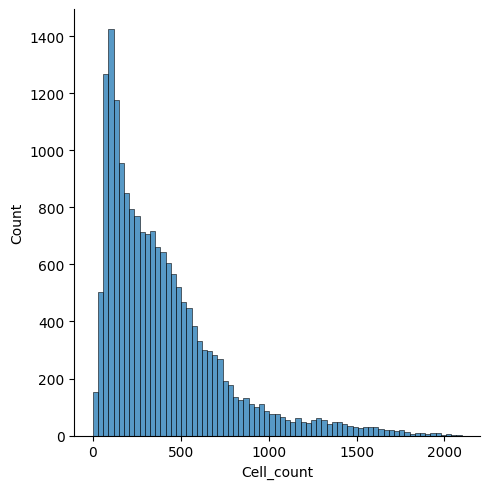

shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 18149.0    │
│ null_count ┆ 0.0        │
│ mean       ┆ 402.752163 │
│ std        ┆ 337.441824 │
│ min        ┆ 1.0        │
│ 25%        ┆ 149.0      │
│ 50%        ┆ 316.0      │
│ 75%        ┆ 538.0      │
│ max        ┆ 2097.0     │
└────────────┴────────────┘


In [17]:
sns.displot(
    data=well_profiles.to_pandas(),
    x="Cell_count"
)
plt.show()

print(well_profiles["Cell_count"].describe())

### 1.3 Median/Mean Cell Count by Well Position

<Figure size 640x480 with 0 Axes>

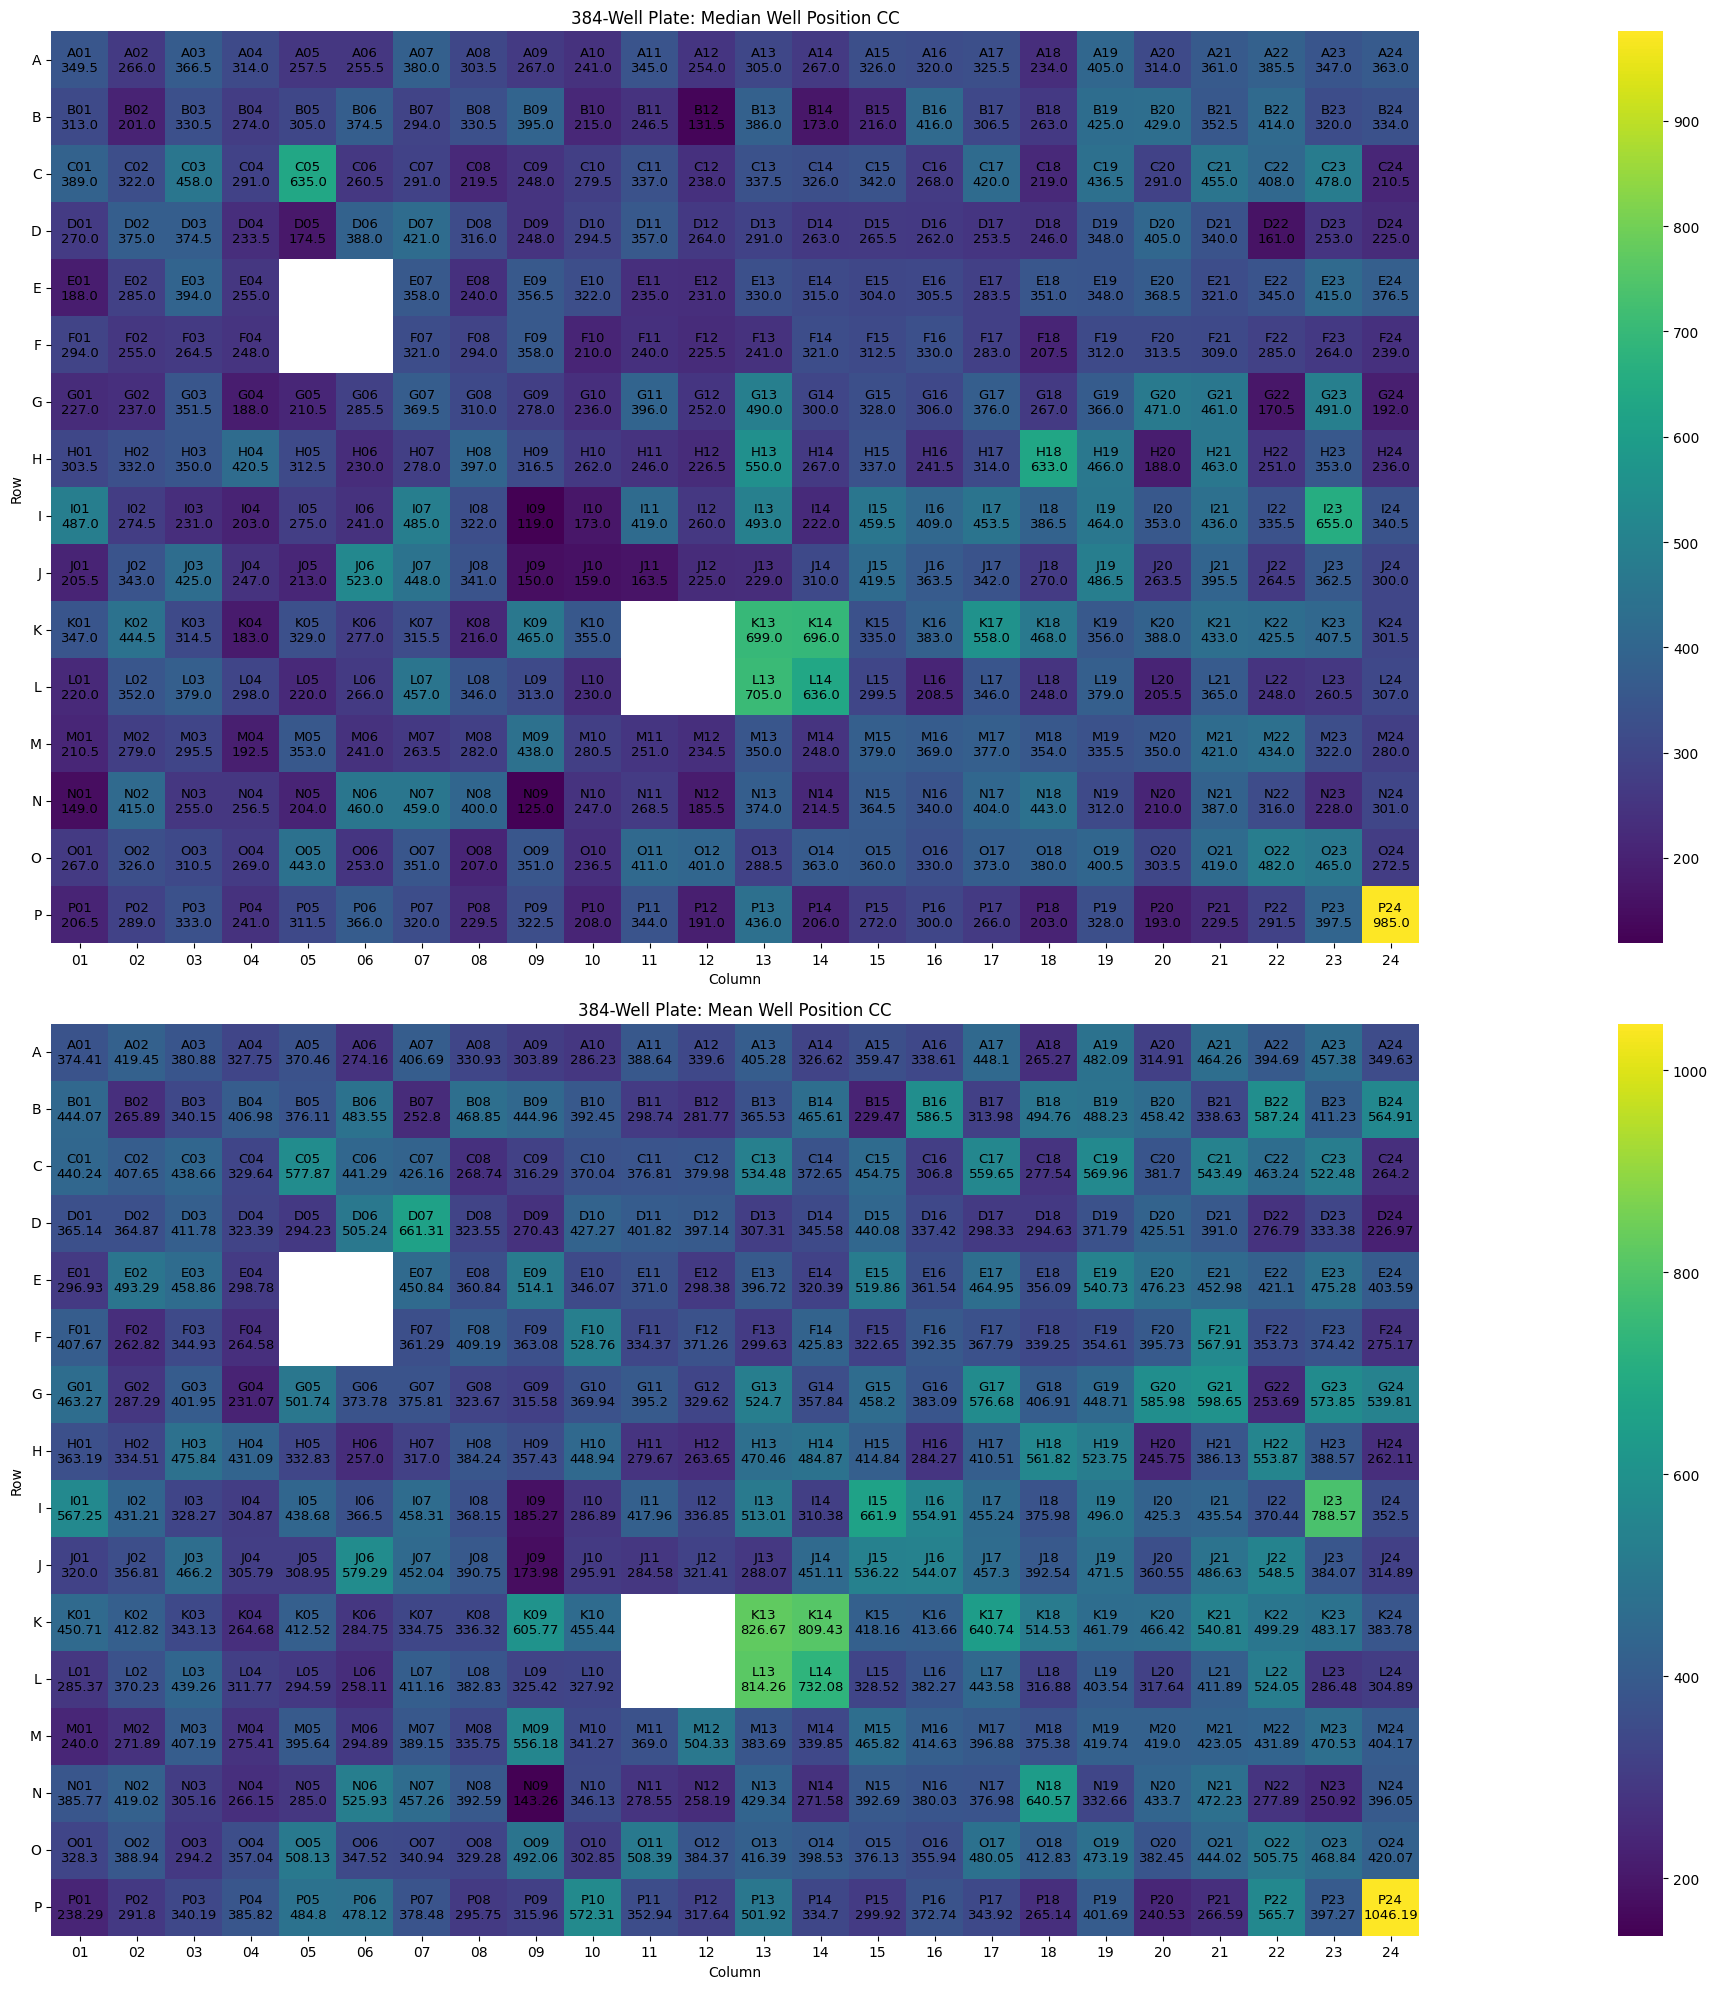

In [18]:
median_well_profile = well_profiles.with_columns(
    pl.col("Metadata_Well").map_elements(well_to_coordinates, return_dtype=pl.List).list.get(1).alias("well_row"),
    pl.col("Metadata_Well").map_elements(well_to_coordinates, return_dtype=pl.List).list.get(2).alias("well_col"),
).group_by("Metadata_Well").agg(
    pl.col("Cell_count").median().alias("CC")
).with_columns(
    pl.col("Metadata_Well").alias("gene_allele")
)

mean_well_profile = well_profiles.filter(~pl.col("dna_is_bg")).group_by("Metadata_Well").agg(
    pl.col("Cell_count").mean().alias("CC")
).with_columns(
    pl.col("Metadata_Well").alias("gene_allele")
)

plt.clf()
fig, axes = plt.subplots(2,1,figsize=(40,20)) ## sharey=True,sharex=True
plot_platemap(
    median_well_profile,
    "Median Well Position CC",
    well_pos_col="Metadata_Well",
    # this is the column to color by (categorical or continuous)
    value_col="CC",
    # these columns will be concatenated into the annotation text
    label_cols=("gene_allele","CC"),
    ax=axes[0], #[plates.index(plate)//2, plates.index(plate)%2],
    value_type="continuous",   # or "continuous"
    continuous_cmap="viridis",  # matplotlib colormap for continuous mode
    grid_square=None
)
plot_platemap(
    mean_well_profile,
    "Mean Well Position CC",
    well_pos_col="Metadata_Well",
    # this is the column to color by (categorical or continuous)
    value_col="CC",
    # these columns will be concatenated into the annotation text
    label_cols=("gene_allele","CC"),
    ax=axes[1], #[plates.index(plate)//2, plates.index(plate)%2],
    value_type="continuous",   # or "continuous"
    continuous_cmap="viridis",  # matplotlib colormap for continuous mode
    grid_square=None
)

fig.subplots_adjust(wspace=-.55, hspace=.05)
plt.tight_layout()
plt.show()

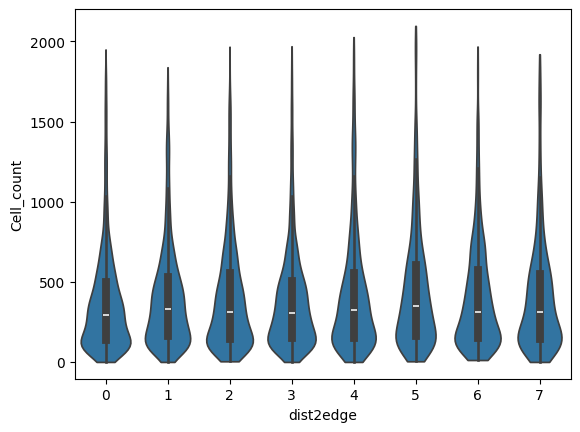

In [19]:
sns.violinplot(data=well_profiles.with_columns(
    pl.col("Metadata_Well").map_elements(lambda x: well_to_coordinates(x)[1], return_dtype=pl.Int16).alias("well_row"),
    pl.col("Metadata_Well").map_elements(lambda x: well_to_coordinates(x)[2], return_dtype=pl.Int16).alias("well_col")
).with_columns(
    pl.struct(["well_row", "well_col"])
      .map_elements(lambda s: compute_distance(s["well_row"], s["well_col"]), return_dtype=pl.Int16)
      .alias("dist2edge")
).to_pandas(), x="dist2edge", y="Cell_count", cut=0)
plt.show()

In [20]:
# def plot_cc_per_plate(well_profile_df):
#     plate_maps = sorted(set(["_".join(plate_map.split("_")[:-1]) for plate_map in sorted(well_profile_df["Metadata_Plate"].unique())]))
#     # print(plate_maps)
#     for plate_map in plate_maps:
#         if (plate_map != "2024_01_17_B7A1R1"):
#             continue
#         plate_map_cc = well_profile_df.filter(pl.col("Metadata_Plate").str.contains(plate_map))
#         plates = sorted(plate_map_cc["Metadata_Plate"].unique().to_list())
#         print(plates)
#         fig, axes = plt.subplots(2,2,figsize=(48,23)) ## sharey=True,sharex=True
#         for plate in plates:
#             plate_info = plate_map_cc.filter(pl.col("Metadata_Plate")==plate)
#             # display(plate_info.filter(pl.col("is_bg")))
#             # print(plates.index(plate))
#             plot_platemap(
#                 plate_info,
#                 plate,
#                 well_pos_col="Metadata_Well",
#                 # this is the column to color by (categorical or continuous)
#                 value_col="Cell_count",
#                 # these columns will be concatenated into the annotation text
#                 label_cols=("Metadata_gene_allele","Cell_count"),
#                 ax=axes[plates.index(plate)//2, plates.index(plate)%2],
#                 value_type="continuous",   # or "continuous"
#                 continuous_cmap="vlag",  # matplotlib colormap for continuous mode
#                 grid_square=None
#             )
#         fig.subplots_adjust(wspace=-.55, hspace=.05)
#         plt.tight_layout()
#         plt.show()
#         # break
# plot_cc_per_plate(well_profiles)

# batch_log_files = [
#     f"{CLASS_RES_DIR}/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/classify.log" \
#     for batch_id in BIO_REP_BATCHES
# ]
# dropped_well_df = pl.DataFrame()
# for logfile in batch_log_files:
#     with open(logfile, encoding="latin-1") as f:
#         lines = f.readlines()
#     dropped_wells = [(l.split(",")[0].strip(), l.split(",")[1].strip()) for l in lines if l.startswith("2025")]
#     dropped_well_df = pl.concat([dropped_well_df, 
#                                  pl.DataFrame({"plate": [well[0] for well in dropped_wells],
#                                                "imaging_well": [well[1].split(":")[0] for well in dropped_wells],
#                                                "gene_allele": [well[1].split(":")[1] for well in dropped_wells]})])
# # dropped_well_df.filter(pl.col("gene_allele").is_in(img_well_qc_sum_dapi.filter(pl.col("is_bg"))["gene_allele"].unique()))

## 2. Cell Count Change Detection

### 2.1 Paired T-test

In [21]:
from scipy.stats import shapiro
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel

MIN_NUMBER_REP = 3

In [22]:
def paired_ttest(dat, reference: str, var: str):
    ## perform stat test
    ## sorted the two alleles to make sure they are from the same plate for paired t-test    
    # if (dat[dat["Metadata_gene_allele"]==reference].shape[0] != dat[dat["Metadata_gene_allele"]==var].shape[0]):
    # pivot to wide: one row per plate
    wide_cc = dat.pivot(index="Metadata_Plate",
                        columns="Metadata_gene_allele",
                        values="Cell_count")
    # print(wide_cc)
    # drop any plate that doesn’t have both measurements
    wide_cc = wide_cc.dropna(subset=[reference, var])
    if wide_cc.shape[0] >= MIN_NUMBER_REP:
        # now run paired t-test
        t_stat, p_val = ttest_rel(wide_cc[var].astype(int), wide_cc[reference].astype(int))
    else:
        t_stat, p_val = None, None

    # df_sampled["PlateID"] = df_sampled["Metadata_Plate"].str.extract(r"(P\d+T\d+)", expand=False)
    ## adjust for edge effect
    # dat["dist2edge"] = dat["Metadata_Well"].apply(lambda x: compute_distance(well_to_coordinates(x)[1], well_to_coordinates(x)[2]))
    # fit Cell_count ~ dist2edge
    # m0 = smf.ols("Cell_count ~ dist2edge", data=dat).fit()
    # dat["resid"] = m0.resid
    # ## calc t-test on residuals corrected for distance to edge
    # wide_res = dat.pivot(index="Metadata_Plate",
    #                     columns="Metadata_gene_allele",
    #                     values="resid")
    # # drop any plate that doesn’t have both measurements
    # wide_res = wide_res.dropna(subset=[reference, var])
    # if wide_res.shape[0] >= 3:
    #     # now run paired t-test
    #     res_t_stat, res_p_val = ttest_rel(wide_res[reference], wide_res[var])
    # else:
    #     res_t_stat, res_p_val = None, None
    
    summary_df = pl.DataFrame(
        {
            "t_stat": t_stat,
            "p_val": p_val,
            # "t_stat_res": res_t_stat,
            # "p_val_res": res_p_val
        }
    )
    summary_df = summary_df.with_columns(
        pl.lit(reference).alias("Gene"), pl.lit(var).alias("gene_variant")
    )
    return summary_df


def ind_ttest(dat, reference: str, var: str):
    ## Per each ref-var well pair on the SAME plate, train and test the classifier
    ## sort the wells to make sure they are from the same plate
    df_sampled = pd.DataFrame()
    for plate in dat["Metadata_Plate"].unique():
        dat = dat[dat["Metadata_Plate"]==plate].dropna().sort_values(["Metadata_gene_allele"])
        # count rows per group
        group_counts = dat.groupby("Metadata_gene_allele").size()
        min_count = group_counts.min()
        # print("Minimum rows in any group:", min_count)
        shuffled = dat.sample(frac=1, random_state=42).reset_index(drop=True)
        # Then take the first min_count rows per group
        sampled_df2 = (
            shuffled
            .groupby("Metadata_gene_allele", group_keys=False)
            .head(min_count)
        )
        df_sampled = pd.concat([df_sampled, sampled_df2])

    # m0 = smf.ols("Cell_count ~ Metadata_Well", data=df_sampled).fit()
    # df_sampled["resid"] = m0.resid
    # print(df_sampled)
    ## require at least two alleles per each VAR and WT group
    if df_sampled.shape[0] >= MIN_NUMBER_REP * 2:
        # now run paired t-test
        t_stat, p_val = ttest_ind(
            df_sampled.loc[df_sampled["Metadata_gene_allele"]==allele, "Cell_count"].astype(int).values,
            df_sampled.loc[df_sampled["Metadata_gene_allele"]==reference, "Cell_count"].astype(int).values, 
            equal_var=False
        )
        # res_t_stat, res_p_val = ttest_ind(df_sampled.loc[df_sampled["Metadata_gene_allele"]==reference, "resid"].values, 
        #                                   df_sampled.loc[df_sampled["Metadata_gene_allele"]==allele, "resid"].values,
        #                                   equal_var=False)
    else:
        t_stat, p_val = None, None
        # res_t_stat, res_p_val = None, None
        
    # break
    summary_df = pl.DataFrame(
        {
            "t_stat": t_stat,
            "p_val": p_val,
            # "t_stat_res": res_t_stat,
            # "p_val_res": res_p_val
        }
    )
    summary_df = summary_df.with_columns(
        pl.lit(reference).alias("Gene"), pl.lit(var).alias("gene_variant")
    )
    return summary_df

In [23]:
well_cc_stats = []
tested_variants = img_well_qc_sum_df.filter((pl.col("gene_allele").is_not_null())&(pl.col("node_type")=="allele")).unique(subset=["gene_allele"])["gene_allele"]
print(len(tested_variants))

for allele in tqdm(well_profiles.select(pl.col("Metadata_gene_allele")).to_pandas()["Metadata_gene_allele"].unique()):
    if allele is None or allele.split("_")[0] == allele or allele not in tested_variants:
        continue

    reference = allele.split("_")[0]
    temp_prof_var = well_profiles.filter(
        (pl.col("Metadata_gene_allele") == allele) | (pl.col("Metadata_gene_allele") == reference)
    ).select(
        pl.col(["Metadata_gene_allele","Metadata_Plate","Metadata_Well","Metadata_Bio_Batch","Cell_count"])
    ).to_pandas()

    bio_batch_list = list(temp_prof_var["Metadata_Bio_Batch"].unique())
    # if (len(bio_batch_list) > 1):
    #     print(bio_batch_list)
    #     print(allele)
        # print(temp_prof_var)
    for bio_batch in bio_batch_list:
        temp_prof = temp_prof_var[temp_prof_var["Metadata_Bio_Batch"]==bio_batch]
        if (temp_prof["Metadata_gene_allele"].unique().shape[0] < 2):
            # print(temp_prof)
            continue
            
        var_profiles = temp_prof[temp_prof["Metadata_gene_allele"]==allele]
        ref_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==reference)&(temp_prof["Metadata_Plate"].isin(var_profiles["Metadata_Plate"].unique()))]
        temp_prof = pd.concat([var_profiles, ref_profiles])
        # if allele == "DES_Ser46Tyr":
        #     display(temp_prof)
        
        # print(batch_plate)
        ## Select ONLY the wells most distant from the edge per each allele to minimize the well-position edge effects
        ## deprecated: let's compare every pair
        # if (ref_profiles.shape[0] > var_profiles.shape[0]):
        #     ref_al_wells = ref_profiles["Metadata_Well"].unique()
        #     well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in ref_al_wells])]
        #     # Sort wells by max distance from edges (descending)
        #     most_centered_well = max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]
        #     ref_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==reference)&(temp_prof["Metadata_Well"]==most_centered_well)]
        # if (ref_profiles.shape[0] < var_profiles.shape[0]):
        #     ref_al_wells = var_profiles["Metadata_Well"].unique()
        #     well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in ref_al_wells])]
        #     # Sort wells by max distance from edges (descending)
        #     most_centered_well = max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]
        #     var_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==allele)&(temp_prof["Metadata_Well"]==most_centered_well)]

        if (bio_batch == "B_11-12"):
            ind_t_res = ind_ttest(
                dat=temp_prof,
                reference=reference,
                var=allele
            ).with_columns(
                pl.lit("").alias("Ref_well"),
                pl.lit("").alias("Var_well"),
                pl.lit(bio_batch).alias("Bio_Batch")
            )
            well_cc_stats.append(
                ind_t_res
            )
            # print(ind_t_res)
            # break
        else:
            ref_wells = ref_profiles["Metadata_Well"].unique()
            var_wells = var_profiles["Metadata_Well"].unique()
            ref_var_pairs = [(ref_well, var_well) for ref_well in ref_wells for var_well in var_wells]
            # print(ref_var_pairs)
            
            ## Per each ref-var well pair on the SAME plate, use paired-t-test to detect differences in CC
            for ref_var in ref_var_pairs:
                ## sort the wells to make sure they are from the same plate
                df_sampled = temp_prof[temp_prof["Metadata_Well"].isin(ref_var)].dropna().sort_values(
                    ["Metadata_Plate", "Metadata_gene_allele"]
                )
                paired_t_res = paired_ttest(
                    dat=df_sampled,
                    reference=reference,
                    var=allele
                ).with_columns(
                    pl.lit(ref_var[0]).alias("Ref_well"),
                    pl.lit(ref_var[1]).alias("Var_well"),
                    pl.lit(bio_batch).alias("Bio_Batch")
                )
                # if allele == "LDLR_Pro196Thr":
                #     display(df_sampled)
                #     display(paired_t_res)
                    
                well_cc_stats.append(
                    paired_t_res
                )
        
well_cc_stats = pl.concat(well_cc_stats,  how="vertical_relaxed")
well_cc_stats = well_cc_stats.rename({"t_stat": "U2OS_t_stat", "p_val": "U2OS_t_pval"}) ## "t_stat_res": "U2OS_paired_tstat_edgedist_resid", "p_val_res": "U2OS_t_edgedist_resid_pval"
well_cc_stats = well_cc_stats.select(["Gene", "gene_variant", "U2OS_t_stat", "U2OS_t_pval", 
                                      "Ref_well", "Var_well", "Bio_Batch"]) ## , "U2OS_paired_tstat_edgedist_resid", "U2OS_t_edgedist_resid_pval",
display(well_cc_stats)

1704


  0%|          | 0/2005 [00:00<?, ?it/s]

100%|██████████| 2005/2005 [00:12<00:00, 164.02it/s]


Gene,gene_variant,U2OS_t_stat,U2OS_t_pval,Ref_well,Var_well,Bio_Batch
str,str,f64,f64,str,str,str
"""DIABLO""","""DIABLO_Ala3Gly""",null,null,"""J12""","""D14""","""B_7-8"""
"""MVK""","""MVK_Asp386Asn""",2.599567,0.040686,"""C15""","""K15""","""B_7-8"""
"""MVK""","""MVK_His20Pro""",0.973229,0.375137,"""C15""","""G19""","""B_7-8"""
"""DCX""","""DCX_Pro191Arg""",-0.668936,0.52842,"""H15""","""L17""","""B_7-8"""
"""AMPD2""","""AMPD2_Glu697Asp""",4.567803,0.019682,"""K02""","""M02""","""B_7-8"""
…,…,…,…,…,…,…
"""PSEN1""","""PSEN1_Met146Leu""",-2.763212,0.027966,"""B10""","""J18""","""B_18-19"""
"""GBA""","""GBA_Arg202Ter""",3.935019,0.005639,"""M09""","""O13""","""B_18-19"""
"""GBA""","""GBA_Met400Ile""",-1.874647,0.102973,"""M09""","""M14""","""B_18-19"""


## 3. Summarize Results

In [24]:
from statsmodels.stats.multitest import multipletests

## drop the null alleles
well_cc_stats = well_cc_stats.filter(
    pl.col("U2OS_t_stat").is_not_null()
)
# 1) get p-values as a numpy array (preserve order and convert None -> np.nan)
pvals = np.array([float(x) if x is not None else np.nan for x in well_cc_stats["U2OS_t_pval"]], dtype=float)
# 2) mask of valid p-values
mask = ~np.isnan(pvals)
# 3) prepare output array filled with NaNs
corrected = np.full(len(pvals), np.nan, dtype=float)
# 4) run multipletests only on valid p-values
if mask.sum() > 0:
    reject, pvals_corr, _, _ = multipletests(pvals[mask], alpha=0.05, method="fdr_bh")  # choose method="fdr_bh" or "bonferroni", etc.
    corrected[mask] = pvals_corr
# 6) attach corrected p-values back to the polars DataFrame
#    with_columns accepts a pl.Series as well as expressions
well_cc_stats = well_cc_stats.with_columns(
    pl.Series("U2OS_cc_t_pval_fdr_bh_adj", corrected)
)

## extract the alleles with only single appearance
variants_single = well_cc_stats.group_by("gene_variant").len().filter(pl.col("len")==1)["gene_variant"]
well_cc_stats_single = well_cc_stats.filter(pl.col("gene_variant").is_in(variants_single))

## extract the alleles with replicates
variants_replicate = well_cc_stats.group_by("gene_variant").len().filter(pl.col("len")>1).unique(subset="gene_variant")["gene_variant"]
well_cc_stats_rep = well_cc_stats.filter(pl.col("gene_variant").is_in(variants_replicate))

## check the consistency between replicates
well_cc_stats_rep_group = well_cc_stats_rep.group_by("gene_variant").agg(
    pl.len().alias("count"),
    (pl.col("U2OS_t_stat")<0).sum().alias("desc"),
    (pl.col("U2OS_t_stat")>0).sum().alias("incr")
)
inconsistent_alleles = well_cc_stats_rep_group.filter((pl.col("count")!=pl.col("desc"))&(pl.col("count")!=pl.col("incr")))
print("Inconsistent CC change across replicates:", inconsistent_alleles)
display(inconsistent_alleles)

## HARD Code to filter bad quality measurements if needed
# well_cc_stats_rep = well_cc_stats_rep.filter(
#     ~((pl.col("Variant")=="MVK_Pro288Leu")&(pl.col("Bio_Batch")=="B_7-8")) &
#     # ~((pl.col("Variant")=="AGXT_Asp201Asn")&(pl.col("Bio_Batch")=="B_7-8")) &
#     ~((pl.col("Variant")=="GSS_Arg125Cys")&(pl.col("Bio_Batch")=="B_7-8")) &
#     ~((pl.col("Variant")=="DES_Pro419Ser")&(pl.col("Var_well")=="B12"))
# )
# display(well_cc_stats_rep.filter(pl.col("Variant").is_in(inconsistent_alleles["Variant"].unique())))

## No problem them merge by mean
well_cc_stats_rep = well_cc_stats_rep.group_by(["Gene", "gene_variant", "Bio_Batch"]).agg(
    pl.col("U2OS_t_stat").mean().alias("U2OS_t_stat"),
    pl.col("U2OS_t_pval").mean().alias("U2OS_t_pval"),
    pl.col("U2OS_cc_t_pval_fdr_bh_adj").mean().alias("U2OS_cc_t_pval_fdr_bh_adj")
).with_columns(
    pl.when(pl.col("gene_variant").is_in(inconsistent_alleles["gene_variant"].unique()))
    .then(pl.lit(1))
    .otherwise(pl.col("U2OS_t_pval"))
    .alias("manual_adj_pval"),
    pl.when(pl.col("gene_variant").is_in(inconsistent_alleles["gene_variant"].unique()))
    .then(pl.lit(1))
    .otherwise(pl.col("U2OS_cc_t_pval_fdr_bh_adj"))
    .alias("manual_adj_pval_fdr_bh_adj")
)

Inconsistent CC change across replicates: shape: (195, 4)
┌────────────────┬───────┬──────┬──────┐
│ gene_variant   ┆ count ┆ desc ┆ incr │
│ ---            ┆ ---   ┆ ---  ┆ ---  │
│ str            ┆ u32   ┆ u32  ┆ u32  │
╞════════════════╪═══════╪══════╪══════╡
│ CCM2_Pro165Thr ┆ 3     ┆ 1    ┆ 2    │
│ CCM2_Gln441Arg ┆ 3     ┆ 2    ┆ 1    │
│ CCM2_Glu366Gln ┆ 3     ┆ 1    ┆ 2    │
│ CCM2_Gly162Glu ┆ 3     ┆ 2    ┆ 1    │
│ CCM2_Pro102Leu ┆ 3     ┆ 2    ┆ 1    │
│ …              ┆ …     ┆ …    ┆ …    │
│ CCM2_Lys23Arg  ┆ 3     ┆ 2    ┆ 1    │
│ GBA_Arg535Cys  ┆ 2     ┆ 1    ┆ 1    │
│ CCM2_Cys211Ser ┆ 3     ┆ 1    ┆ 2    │
│ CCM2_Ala205Asp ┆ 3     ┆ 2    ┆ 1    │
│ CCM2_Val190Met ┆ 3     ┆ 2    ┆ 1    │
└────────────────┴───────┴──────┴──────┘


gene_variant,count,desc,incr
str,u32,u32,u32
"""CCM2_Pro165Thr""",3,1,2
"""CCM2_Gln441Arg""",3,2,1
"""CCM2_Glu366Gln""",3,1,2
"""CCM2_Gly162Glu""",3,2,1
"""CCM2_Pro102Leu""",3,2,1
…,…,…,…
"""CCM2_Lys23Arg""",3,2,1
"""GBA_Arg535Cys""",2,1,1
"""CCM2_Cys211Ser""",3,1,2


In [25]:
# # 2. Define the UDF (User-Defined Function)
# # This function will take a Polars Series (a column batch) and return the corrected Series.
# def benjamini_hochberg_correction(p_series: pl.Series) -> pl.Series:
#     # Convert the Polars Series to a NumPy array for statsmodels
#     pvals_in = p_series.to_numpy()
    
#     # Apply the multipletests function
#     # It returns (reject, pvals_corrected, _, _). We only care about the 2nd element.
#     # Note: alpha is for determining rejection, but the corrected p-values (q-values) 
#     # are calculated independently of alpha for 'fdr_bh'.
#     _, pvals_corrected, _, _ = multipletests(
#         pvals=pvals_in, 
#         alpha=0.05, 
#         method='fdr_bh'
#     )
    
#     # Convert the NumPy array back to a Polars Series
#     return pl.Series(pvals_corrected)

    
well_cc_stats_final = pl.concat([
    well_cc_stats_rep,
    well_cc_stats_single.with_columns(
        pl.col("U2OS_t_pval").alias("manual_adj_pval"),
        pl.col("U2OS_cc_t_pval_fdr_bh_adj").alias("manual_adj_pval_fdr_bh_adj")
    ).select(pl.col(well_cc_stats_rep.columns))
]).with_columns(
    pl.col("manual_adj_pval").alias("U2OS_cc_t_pval"),
    pl.col("U2OS_t_stat").alias("U2OS_cc_t_stat"),
    pl.col("manual_adj_pval_fdr_bh_adj").alias("U2OS_cc_t_pval_fdr_bh_adj")
)

well_cc_stats_final = well_cc_stats_final.select(["Gene", "gene_variant", "Bio_Batch", "U2OS_cc_t_stat", "U2OS_cc_t_pval", "U2OS_cc_t_pval_fdr_bh_adj"]) ## , "U2OS_paired_tstat_edgedist_resid", "U2OS_t_edgedist_resid_pval",

### 3.1 Visual QC

In [26]:
OUT_IMGS_DIR = ""
sys.path.append("./cell_img_visualization")
from display_img import *

## Manual visualization
### DES_Pro419Ser: drop B12
# plot_allele(allele_meta_df_dict["2024_01_Batch_7-8"], "DES_Pro419Ser", "DAPI", 
#             plate_img_qc=img_well_qc_sum_dict["2024_01_Batch_7-8"].with_columns(
#                 pl.col("channel").replace("DNA", "DAPI").alias("channel")
#             ), ref_well=["J21"], var_well=["L10"],
#             site="05", max_intensity=0.99, display=True, imgs_dir=TIFF_IMGS_DIR)
# plot_allele(allele_meta_df_dict["2024_01_Batch_7-8"], "DES_Pro419Ser", "DAPI", 
#             plate_img_qc=img_well_qc_sum_dict["2024_01_Batch_7-8"].with_columns(
#                 pl.col("channel").replace("DNA", "DAPI").alias("channel")
#             ), ref_well=["J21"], var_well=["B12"],
#             site="05", max_intensity=0.99, display=True, imgs_dir=TIFF_IMGS_DIR)

# plot_allele(allele_meta_df_dict["2024_01_Batch_7-8"], "GSS_Arg125Cys", "DAPI", 
#             plate_img_qc=img_well_qc_sum_dict["2024_01_Batch_7-8"].with_columns(
#                 pl.col("channel").replace("DNA", "DAPI").alias("channel")
#             ),
#             site="05", max_intensity=0.99, display=True, imgs_dir=TIFF_IMGS_DIR)

In [27]:
plot_allele_single_plate(
    img_well_qc_sum_df.filter(
        (pl.col("Metadata_Bio_Rep")=="2024_12_Batch_11-12"),
        pl.col("channel")=="DNA"
    ), 
    "GSS_Arg125Cys", 
    "DAPI", 
    plate_img_qc=img_well_qc_sum_df,
    site="05", 
    show_plot=True, 
    imgs_dir=TIFF_IMGS_DIR
)

ColumnNotFoundError: unable to find column "Metadata_Bio_Rep"; valid columns: ["plate", "well", "channel", "mean", "std", "perc_25", "perc_50", "perc_75", "perc_80", "perc_90", "perc_95", "perc_99", "Metadata_Batch", "mean_plate", "std_plate", "perc_25_plate", "median_plate", "perc_75_plate", "perc_80_plate", "perc_90_plate", "perc_95_plate", "perc_99_plate", "s2n_ratio_raw", "s2n_ratio", "Metadata_Bio_Batch", "is_bg", "plate_id", "plate_well", "plate_map_name", "well_position", "symbol", "gene_allele", "imaging_well", "imaging_plate_R1", "imaging_plate_R2", "node_type", "orf_id_wt", "ccsb_mutation_id", "nt_change_cdna", "aa_change", "allele_set", "imaging_plate", "batch1", "batch2", "clone_ID", "vector", "notes", "quad", "c96", "r96", "r384", "c384", "r384_letter", "source_plate", "source_well", "source_numb", "dest_plate", "dest_well", "dest_numb", "technical_replicate", "symbol_original", "sequencing_confidence", "hgmd_ID", "clinvar_allele_ID", "clinvar_clinical_significance"]

In [28]:
# Total number of increase vs. decrease
total = well_cc_stats_final.shape[0]

## We are comparing REF - VAR in the paired_ttest ttest_rel
## The t-statistic is calculated as np.mean(a - b)/se, where se is the standard error.
## Thus, t-stat < 0 means REF more than VAR --> VAR decreasing CC
per_dec = well_cc_stats_final.filter(pl.col("U2OS_cc_t_stat") < 0).shape[0]
per_inc = well_cc_stats_final.filter(pl.col("U2OS_cc_t_stat") > 0).shape[0]

print("Total decreasin vs increasing percent:")
print(f"{per_dec}, {per_dec / total * 100:.2f} %")
print(f"{per_inc}, {per_inc / total * 100:.2f} %")

dec_sig = well_cc_stats_final.filter(pl.col("U2OS_cc_t_pval") < 0.05).filter(pl.col("U2OS_cc_t_stat") < 0).shape[0]
inc_sig = well_cc_stats_final.filter(pl.col("U2OS_cc_t_pval") < 0.05).filter(pl.col("U2OS_cc_t_stat") > 0).shape[0]

dec_sig_adj = well_cc_stats_final.filter(pl.col("U2OS_cc_t_pval_fdr_bh_adj") < 0.05).filter(pl.col("U2OS_cc_t_stat") < 0).shape[0]
inc_sig_adj = well_cc_stats_final.filter(pl.col("U2OS_cc_t_pval_fdr_bh_adj") < 0.05).filter(pl.col("U2OS_cc_t_stat") > 0).shape[0]

print("Number sig decreases")
print(f"Orig p-val: {dec_sig}, {dec_sig / total * 100:.2f}% | BH-corrected p-val: {dec_sig_adj}, {dec_sig_adj / total * 100:.2f}%")
print("Number sig increases")
print(f"Orig p-val: {inc_sig}, {inc_sig / total * 100:.2f}% | BH-corrected p-val: {inc_sig_adj}, {inc_sig_adj / total * 100:.2f}%")

Total decreasin vs increasing percent:
691, 50.44 %
677, 49.42 %
Number sig decreases
Orig p-val: 327, 23.87% | BH-corrected p-val: 255, 18.61%
Number sig increases
Orig p-val: 268, 19.56% | BH-corrected p-val: 227, 16.57%


In [29]:
well_cc_stats_final#.unique("gene_variant")

Gene,gene_variant,Bio_Batch,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_cc_t_pval_fdr_bh_adj
str,str,str,f64,f64,f64
"""TGIF1""","""TGIF1_Thr280Ala""","""B_18-19""",10.337178,0.000806,0.003501
"""CCM2""","""CCM2_Pro102Leu""","""B_13-14""",-1.180643,1.0,1.0
"""CCM2""","""CCM2_Thr267Asn""","""B_13-14""",1.573241,1.0,1.0
"""SDHD""","""SDHD_Arg70Thr""","""B_13-14""",6.934747,0.000245,0.001646
"""CCM2""","""CCM2_Ala205Thr""","""B_13-14""",3.996587,1.0,1.0
…,…,…,…,…,…
"""PPP2R2B""","""PPP2R2B_Arg451Gln""","""B_18-19""",15.43204,0.000005,0.000143
"""SLC36A3""","""SLC36A3_Lys167Glu""","""B_18-19""",5.770244,0.002197,0.00846
"""PSEN1""","""PSEN1_Met146Leu""","""B_18-19""",-2.763212,0.027966,0.058698


In [30]:
well_cc_stats_final.write_csv(f"{CC_ABUND_DIR}/cell_count_diff_summary.csv")
well_cc_stats_final.filter(
    pl.col("Gene")!="CCM2",
    pl.col("Bio_Batch")!="B_18-19",
).write_csv(f"{CC_ABUND_DIR}/cell_count_diff_summary_oneperc.csv")